In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations

In [173]:
Stage=2
folder_name='experiment and result stage'+str(Stage)
Dataset="Mnist" #if baseline then Basline .../...
baseline=None #None or 11 33 55
if baseline:
  Dataset=Dataset+"/"+baseline
filename="Copy of " + Dataset + "_result.csv"
methods=['deeplift', 'integrated_gradients']
method='integrated_gradients'
flops_dict = {"conv1x1FLOPS": 0.012544, "conv1x1_3x3FLOPS": 0.909, "conv1x1_5x5FLOPS": 2.515, "totalFLOPS": 13.274}
#branch_baseline_flop=0
#flops_dict = {"branch1": branch_baseline_flop, "branch2": branch_baseline_flop, "branch3": branch_baseline_flop, "totalFLOPS": 0}
end_epoch=0

In [174]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed_data/'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist/Copy of Mnist_result.csv


In [175]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [176]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    if not baseline:
      df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
      df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)
    else:
      df.rename(columns={'branch1.1': 'branch1', 'branch2.1': 'branch2', 'branch3.1': 'branch3'}, inplace=True)
      df.drop(columns=['branch1.0', 'branch2.0', 'branch3.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [177]:
def normalize_feature_attribution(df, threshold=70):
    # Columns to be normalized
    if not baseline:
      layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']
    else:
      layers=[['branch1.0','branch2.0','branch3.0']]

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    if not baseline:
      df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)
    else:
      df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

get standard deviation for each layer's feature attribution

In [178]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [179]:
FA_SD.to_csv(save_folder+"/"+method+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" all_FA_SD.csv")

In [180]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,std_norm_conv1x1,std_norm_conv1x1_3x3,std_norm_conv1x1_5x5,avg_std,train accuracy epoch0,test accuracy epoch0,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.192050,0.270430,0.537521,0.046458,0.151249,0.163936,0.120548,92.029556,93.443333,0.012544,0.909,2.515,13.274
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.187212,0.309344,0.503444,0.037042,0.147395,0.156114,0.113517,91.006556,93.688667,0.012544,0.909,2.515,13.274
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.212985,0.308728,0.478287,0.040026,0.131329,0.149145,0.106833,89.630333,93.467333,0.012544,0.909,2.515,13.274
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.180605,0.275695,0.543700,0.034498,0.141168,0.152850,0.109505,92.095111,95.512667,0.012544,0.909,2.515,13.274
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.176033,0.305098,0.518869,0.044818,0.138108,0.150796,0.111241,91.359222,95.524000,0.012544,0.909,2.515,13.274
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.199399,0.302327,0.498274,0.042293,0.139346,0.154458,0.112032,90.030444,94.718000,0.012544,0.909,2.515,13.274
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.268895,0.242117,0.488989,0.085867,0.190773,0.197529,0.158056,91.615111,92.625333,0.012544,0.909,2.515,13.274
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.225208,0.308641,0.466152,0.047967,0.171744,0.186191,0.135301,90.938667,93.822000,0.012544,0.909,2.515,13.274
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.250329,0.337536,0.412135,0.059787,0.157207,0.172871,0.129955,89.597778,93.330000,0.012544,0.909,2.515,13.274
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.268649,0.249897,0.481454,0.062869,0.162418,0.173364,0.132883,91.683111,95.156667,0.012544,0.909,2.515,13.274


# Graph

In [181]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'std_norm' in col]
    variance_columns.append('avg_std')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


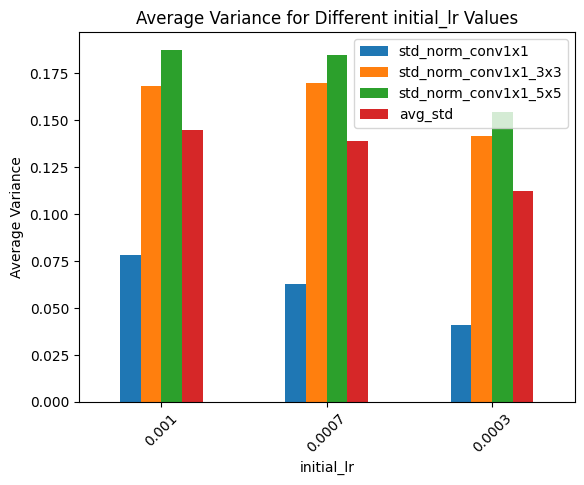

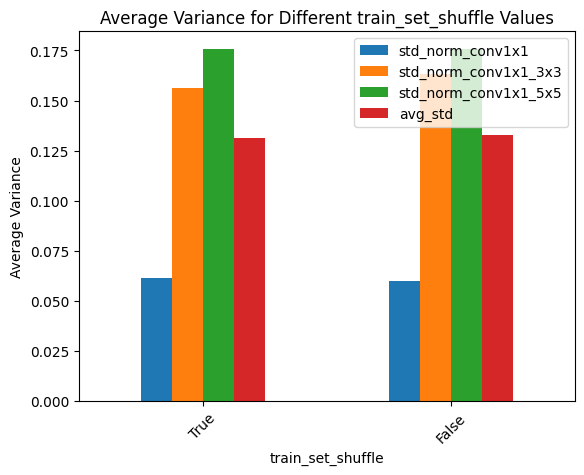

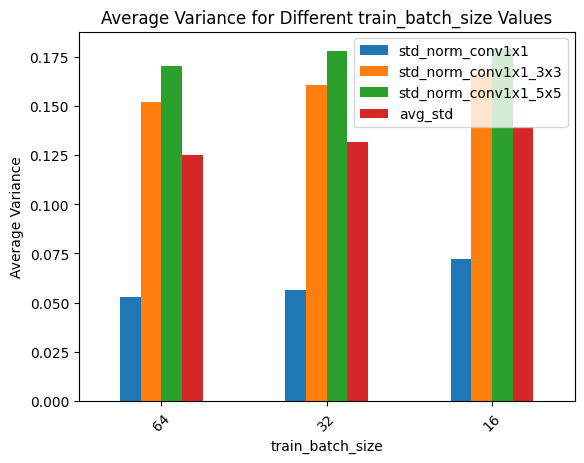

In [182]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

# Paired T test

In [183]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [184]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [185]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [186]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [187]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003],
 'train_set_shuffle': [True, False],
 'train_batch_size': [64, 32, 16]}

In [188]:
def get_significant_results(df, hyperparams_choice_list):
  if not baseline:
    values_to_compare=['std_norm_conv1x1','std_norm_conv1x1_3x3','std_norm_conv1x1_5x5','avg_std']
  else:
    values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [189]:
get_significant_results(FA_SD, hyperparams_choice_list)

Values to compare: std_norm_conv1x1 variable_pair: (0.001, 0.0003) T-statistic: 4.529748156843056 One-sided P-value: 0.0031134624147629883
Values to compare: std_norm_conv1x1 variable_pair: (0.0007, 0.0003) T-statistic: 4.9478618677493404 One-sided P-value: 0.0021464240714971186


Values to compare: std_norm_conv1x1_3x3 variable_pair: (0.001, 0.0003) T-statistic: 11.565190996334602 One-sided P-value: 4.2397022510348255e-05
Values to compare: std_norm_conv1x1_3x3 variable_pair: (0.0007, 0.0003) T-statistic: 9.898098678208056 One-sided P-value: 8.97751012204267e-05


Values to compare: std_norm_conv1x1_5x5 variable_pair: (0.001, 0.0003) T-statistic: 12.390452646428097 One-sided P-value: 3.0338687428959625e-05
Values to compare: std_norm_conv1x1_5x5 variable_pair: (0.0007, 0.0003) T-statistic: 9.134353139499558 One-sided P-value: 0.00013172641729558375


Values to compare: avg_std variable_pair: (0.001, 0.0003) T-statistic: 9.549996677789226 One-sided P-value: 0.00010654790176434619
Value

#layer feature attribution rank frequency comparison

In [190]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [191]:
# Select the columns of interest
if not baseline:
  cols_of_interest = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
else:
  cols_of_interest = ['branch1', 'branch2', 'branch3']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-191-fa4b0649080b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


213    102
123     78
132     44
231     36
312      7
321      3
Name: rank_combination, dtype: int64